# (논문) CAT/DOG_ver.2
> CNN and CAM

- toc:true
- branch: master
- badges: true
- comments: true
- author: 김하영
- categories: [Study]

---

### import 

In [1]:
import torch 
from fastai.vision.all import *
import cv2

---

### data 

In [2]:
path=untar_data(URLs.PETS)/'images'

In [3]:
path

Path('/home/khy/.fastai/data/oxford-iiit-pet/images')

In [4]:
files=get_image_files(path)

In [5]:
def label_func(f):
    if f[0].isupper():
        return 'cat' 
    else: 
        return 'dog' 

In [6]:
dls=ImageDataLoaders.from_name_func(path,files,label_func,item_tfms=Resize(512)) 

---

### learn

In [7]:
lrnr=cnn_learner(dls,resnet34,metrics=error_rate)
lrnr.fine_tune(1)

---

### sample

#### 1st CNN and CAM

In [8]:
get_image_files(path)[0]

Path('/home/khy/.fastai/data/oxford-iiit-pet/images/boxer_128.jpg')

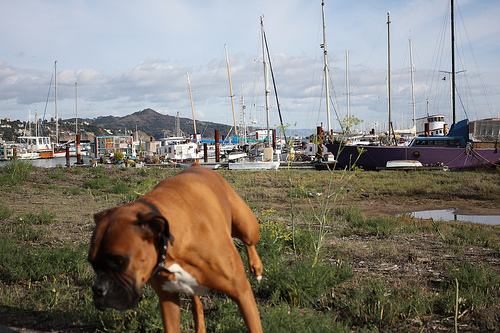

In [9]:
img = PILImage.create(get_image_files(path)[0])
img

In [10]:
x, = first(dls.test_dl([img]))  #이미지 텐서화

In [11]:
x.shape

torch.Size([1, 3, 512, 512])

In [12]:
net1=lrnr.model[0]
net2=lrnr.model[1] 

In [13]:
net2 = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1), 
    torch.nn.Flatten(),
    torch.nn.Linear(512,out_features=2,bias=False))

In [14]:
net=torch.nn.Sequential(net1,net2)

In [15]:
lrnr2=Learner(dls,net,metrics=accuracy) 

In [16]:
lrnr2.fine_tune(25) 

In [17]:
dls.vocab

['cat', 'dog']

- (고양이,강아지)라고 생각한 확률 

In [18]:
a=net(x).tolist()[0][0]
b=net(x).tolist()[0][1]
np.exp(a)/(np.exp(a)+np.exp(b)), np.exp(b)/(np.exp(a)+np.exp(b))

(1.7321613661884395e-05, 0.999982678386338)

- CAM

In [19]:
camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())

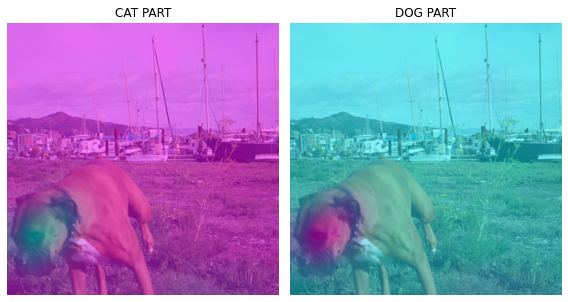

In [20]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("CAT PART")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DOG PART")
#
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

#### ★ **판단 근거가 강할수록 파란색 $\to$ 보라색 변함**

---

#### 2nd CNN and CAM

- MODE 1 만들기

    - 가중치 재설정

In [21]:
test=camimg[1]-torch.min(camimg[1])

In [22]:
A1=torch.exp(-0.015*test)  

In [23]:
A2=1-A1

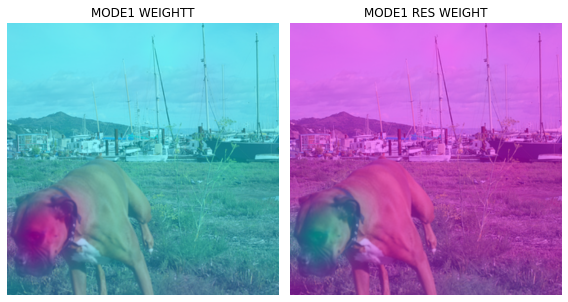

In [24]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(A2.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("MODE1 WEIGHTT")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(A1.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("MODE1 RES WEIGHT")
#
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [283]:
#mode1_res*x
X1=np.array(A1.to("cpu").detach(),dtype=np.float32)
Y1=torch.Tensor(cv2.resize(X1,(512,512),interpolation=cv2.INTER_LINEAR))
x1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1*0.9)

In [284]:
#mode1*x
X12=np.array(A2.to("cpu").detach(),dtype=np.float32)
Y12=torch.Tensor(cv2.resize(X12,(512,512),interpolation=cv2.INTER_LINEAR))
x12=x.squeeze().to('cpu')*Y12-torch.min(x.squeeze().to('cpu')*Y12)

---

### 히스토그램 평활화

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


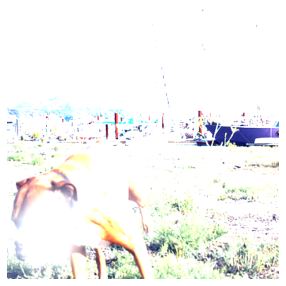

In [29]:
x1.show()
plt.savefig('mode1_res')

In [30]:
img = cv2.imread('mode1_res.png')

In [31]:
img.shape

(360, 360, 3)

In [32]:
img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

In [33]:
img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

In [34]:
img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

- 에러나는 부분

In [ ]:
cv2.imshow('Color input image', img)
cv2.imshow('Histogram equalized', img_output)

- 그림이 나오긴 했는데... 조금 이상하다.

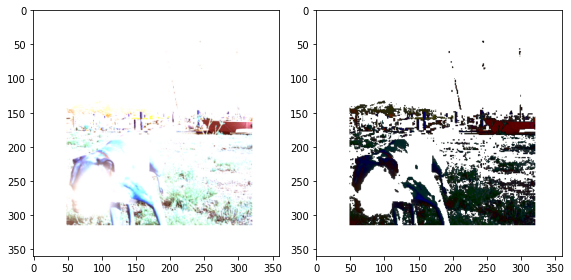

In [36]:
fig, (ax1,ax2) = plt.subplots(1,2) 
ax1.imshow(img)
ax2.imshow(img_output)
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

---

- 1st CAM 결과를 분리하면 아래와 같음.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


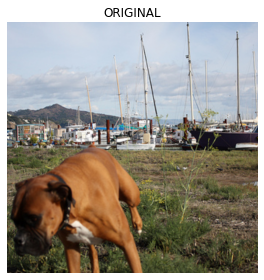

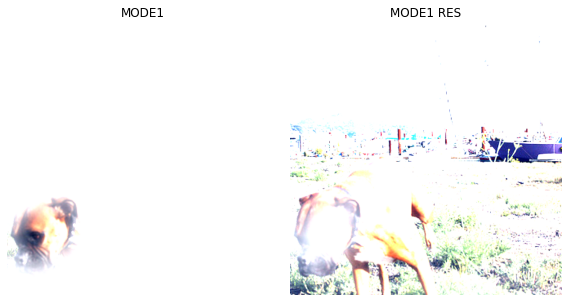

In [285]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("ORIGINAL")
fig.set_figwidth(4)            
fig.set_figheight(4)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
(x12-torch.min(x12)).squeeze().show(ax=ax1)  #MODE1
x1.squeeze().show(ax=ax2)  #MODE1_res
ax1.set_title("MODE1")
ax2.set_title("MODE1 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [286]:
x1=x1.reshape(1,3,512,512)

In [287]:
net1.to('cpu')
net2.to('cpu')

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=2, bias=False)
)

In [288]:
camimg1 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x1).squeeze())

- CAM

    - mode1_res에 CAM 결과 올리기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


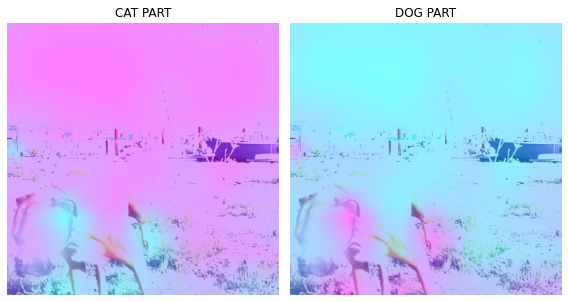

In [289]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
x1.squeeze().show(ax=ax1)
ax1.imshow(camimg1[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("CAT PART")
#
x1.squeeze().show(ax=ax2)
ax2.imshow(camimg1[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DOG PART")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

    - 첫번째 CAM결과와 비교

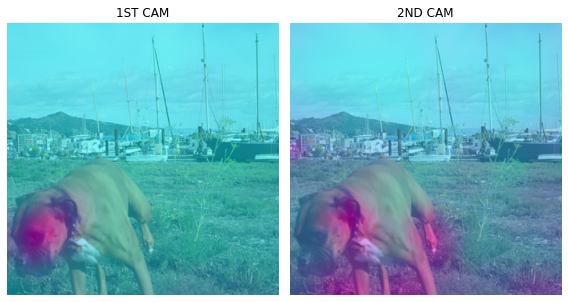

In [290]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("1ST CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg1[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("2ND CAM")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [291]:
a1=net(x1).tolist()[0][0]
b1=net(x1).tolist()[0][1]
np.exp(a1)/(np.exp(a1)+np.exp(b1)), np.exp(b1)/(np.exp(a1)+np.exp(b1))

(0.07156445481742568, 0.9284355451825743)

---

#### 3rd CNN and CAM

- MODE 2 만들기

In [292]:
test1=camimg1[1]-torch.min(camimg1[1])

In [293]:
A3=torch.exp(-0.03*test1)  

In [294]:
A4=1-A3

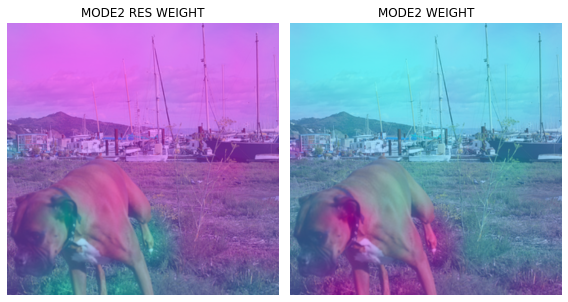

In [295]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(A3.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("MODE2 RES WEIGHT")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(A4.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("MODE2 WEIGHT")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [296]:
X2=np.array(A3.to("cpu").detach(),dtype=np.float32)
Y2=torch.Tensor(cv2.resize(X2,(512,512),interpolation=cv2.INTER_LINEAR))
x2=x.squeeze().to('cpu')*Y1*Y2-torch.min(x.squeeze().to('cpu')*Y1*Y2)

In [318]:
X22=np.array(A4.to("cpu").detach(),dtype=np.float32)
Y22=torch.Tensor(cv2.resize(X22,(512,512),interpolation=cv2.INTER_LINEAR))
x22=x.squeeze().to('cpu')*Y1*Y22-torch.min(x.squeeze().to('cpu')*Y1*Y22)*2.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


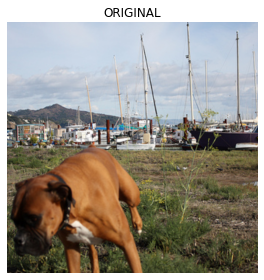

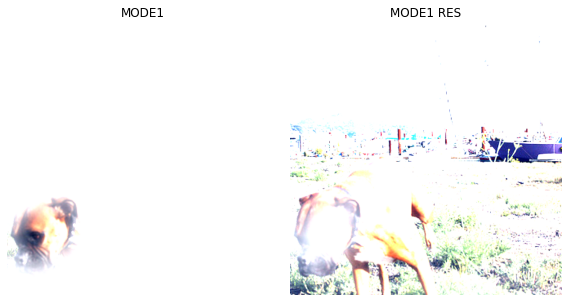

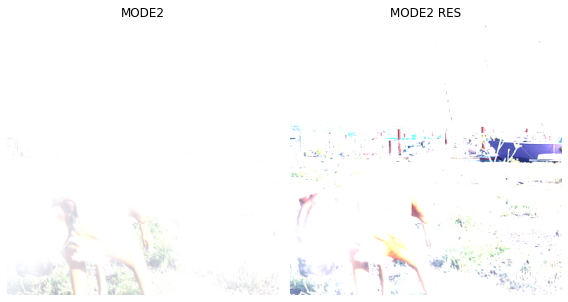

In [319]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("ORIGINAL")
fig.set_figwidth(4)            
fig.set_figheight(4)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
x12.squeeze().show(ax=ax1)  #MODE1
x1.squeeze().show(ax=ax2)  #MODE1_res
ax1.set_title("MODE1")
ax2.set_title("MODE1 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
x22.squeeze().show(ax=ax1)  #MODE2
x2.squeeze().show(ax=ax2)  #MODE2_res
ax1.set_title("MODE2")
ax2.set_title("MODE2 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [310]:
x2=x2.reshape(1,3,512,512)

In [320]:
net1.to('cpu')
net2.to('cpu')

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=2, bias=False)
)

In [321]:
camimg2 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x2).squeeze())

- CAM

    - mode2_res에 CAM 결과 올리기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


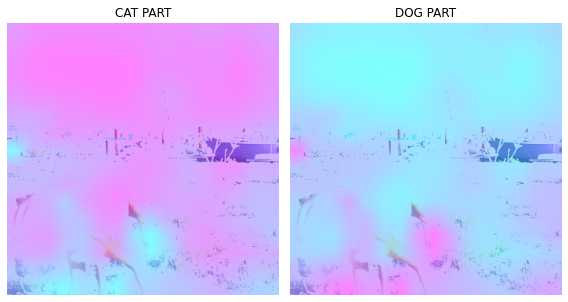

In [322]:
fig, (ax1, ax2) = plt.subplots(1,2) 
#
x2.squeeze().show(ax=ax1)
ax1.imshow(camimg2[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("CAT PART")
#
x2.squeeze().show(ax=ax2)
ax2.imshow(camimg2[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DOG PART")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

    - 첫번째, 두번째 CAM결과와 비교

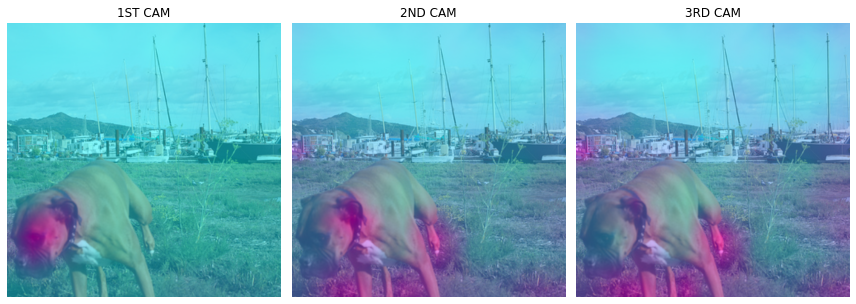

In [323]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("1ST CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg1[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("2ND CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax3)
ax3.imshow(camimg2[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax3.set_title("3RD CAM")
fig.set_figwidth(12)            
fig.set_figheight(12)
fig.tight_layout()

In [324]:
a2=net(x2).tolist()[0][0]
b2=net(x2).tolist()[0][1]
np.exp(a2)/(np.exp(a2)+np.exp(b2)), np.exp(b2)/(np.exp(a2)+np.exp(b2))

(0.27261557988582774, 0.7273844201141721)

---

#### 4th CNN and CAM

- MODE 3 만들기

In [325]:
test2=camimg2[1]-torch.min(camimg2[1])

In [326]:
A5=torch.exp(-0.06*test2)  

In [327]:
A6=1-A5

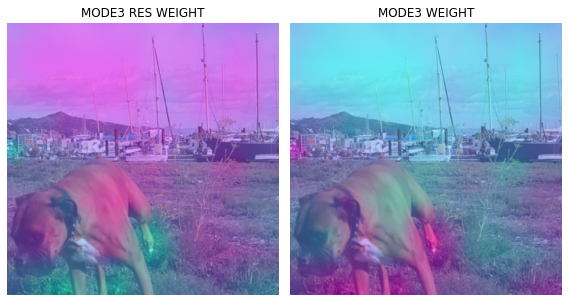

In [328]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(A5.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("MODE3 RES WEIGHT")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(A6.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("MODE3 WEIGHT")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [332]:
X3=np.array(A5.to("cpu").detach(),dtype=np.float32)
Y3=torch.Tensor(cv2.resize(X3,(512,512),interpolation=cv2.INTER_LINEAR))
x3=x.squeeze().to('cpu')*Y1*Y2*Y3-torch.min(x.squeeze().to('cpu')*Y1*Y2*Y3)

In [346]:
X32=np.array(A6.to("cpu").detach(),dtype=np.float32)
Y32=torch.Tensor(cv2.resize(X32,(512,512),interpolation=cv2.INTER_LINEAR))
x32=x.squeeze().to('cpu')*Y1*Y2*Y32-torch.min(x.squeeze().to('cpu')*Y1*Y2*Y32)*2.8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


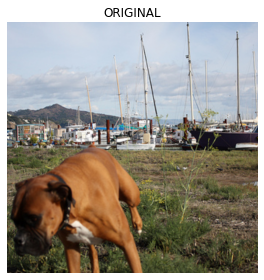

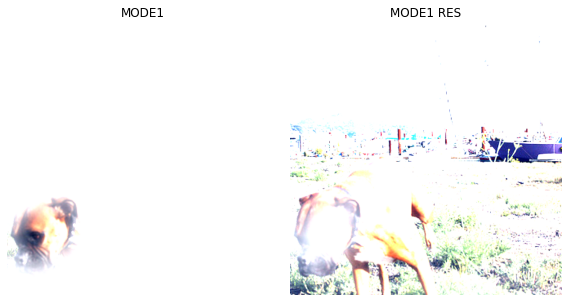

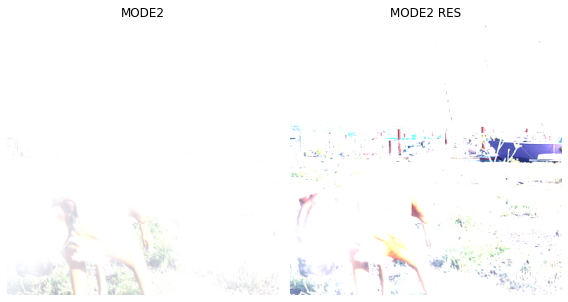

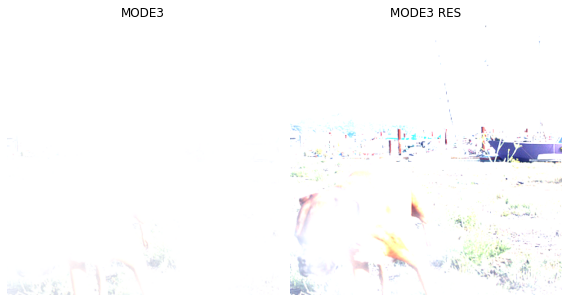

In [347]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("ORIGINAL")
fig.set_figwidth(4)            
fig.set_figheight(4)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
x12.squeeze().show(ax=ax1)  #MODE1
x1.squeeze().show(ax=ax2)  #MODE1_res
ax1.set_title("MODE1")
ax2.set_title("MODE1 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
x22.squeeze().show(ax=ax1)  #MODE2
x2.squeeze().show(ax=ax2)  #MODE2_res
ax1.set_title("MODE2")
ax2.set_title("MODE2 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
(x32).squeeze().show(ax=ax1)  #MODE3
x3.squeeze().show(ax=ax2)  #MODE3_res
ax1.set_title("MODE3")
ax2.set_title("MODE3 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [348]:
x3=x3.reshape(1,3,512,512)

In [349]:
net1.to('cpu')
net2.to('cpu')

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=2, bias=False)
)

In [350]:
camimg3 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x3).squeeze())

- CAM

    - mode3_res에 CAM 결과 올리기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


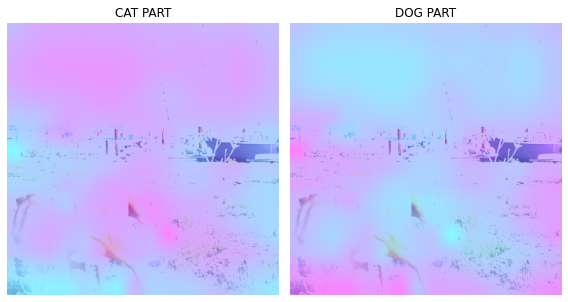

In [351]:
fig, (ax1, ax2) = plt.subplots(1,2) 
#
x3.squeeze().show(ax=ax1)
ax1.imshow(camimg3[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("CAT PART")
#
x3.squeeze().show(ax=ax2)
ax2.imshow(camimg3[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DOG PART")
#
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

    - 첫번째, 두번째, 세번째 CAM결과와 비교

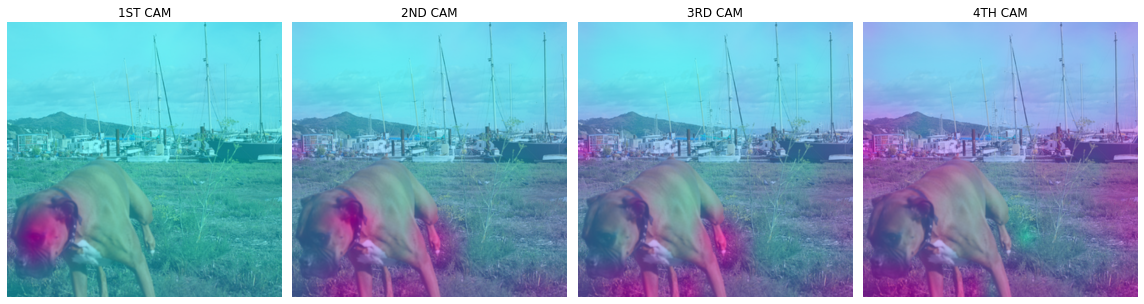

In [352]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("1ST CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg1[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("2ND CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax3)
ax3.imshow(camimg2[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax3.set_title("3RD CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax4)
ax4.imshow(camimg3[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax4.set_title("4TH CAM")
#
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

In [353]:
a3=net(x3).tolist()[0][0]
b3=net(x3).tolist()[0][1]
np.exp(a3)/(np.exp(a3)+np.exp(b3)), np.exp(b3)/(np.exp(a3)+np.exp(b3))

(0.5805579321414458, 0.41944206785855426)